# Entrenamiento de Behavioral Cloning CNN
Este notebook entrena una red neuronal convolucional para predecir ángulos de dirección a partir de imágenes capturadas en Webots.

In [5]:
# Clonar el repositorio con las imágenes y CSV
!git clone https://github.com/juliomestas/navegacion_autonoma.git

Cloning into 'navegacion_autonoma'...
remote: Enumerating objects: 56787, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 56787 (delta 0), reused 0 (delta 0), pack-reused 56782 (from 2)
Receiving objects: 100% (56787/56787), 1.44 GiB | 17.37 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (36128/36128), done.


In [1]:
# ========================
# 1. LIBRERÍAS NECESARIAS
# ========================
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Lambda
from tensorflow.keras.utils import img_to_array
from sklearn.model_selection import train_test_split

In [2]:
# ========================
# 2. FUNCIONES DE AUGMENTACIÓN
# ========================
def augment_brightness(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    ratio = 0.5 + np.random.uniform()
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * ratio, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def add_random_shadow(image):
    h, w = image.shape[:2]
    x1, x2 = np.random.randint(0, w, 2)
    xm = np.mgrid[0:h, 0:w][1]
    shadow_mask = xm > (x2 - x1) / h * np.mgrid[0:h, 0:w][0] + x1
    shadow_image = image.copy()
    shadow_image[shadow_mask] = shadow_image[shadow_mask] * 0.5
    return shadow_image.astype(np.uint8)

def translate_image(img, angle, range_x=50):
    trans_x = np.random.uniform(-range_x, range_x)
    angle += trans_x * 0.002
    M = np.float32([[1, 0, trans_x], [0, 1, 0]])
    height, width = img.shape[:2]
    img = cv2.warpAffine(img, M, (width, height))
    return img, angle

def apply_augmentations(img, angle):
    img = augment_brightness(img)
    img = add_random_shadow(img)
    img, angle = translate_image(img, angle)
    return img, angle

In [3]:
# ========================
# 3. FUNCIÓN PARA CARGAR DATOS
# ========================
def load_augmented_data(base_path):
    df = pd.read_csv(os.path.join(base_path, 'angles.csv'))
    X, y = [], []
    for _, row in df.iterrows():
        img_path = os.path.join(base_path, 'captured_images', row['filename'])
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.resize(img, (200, 66))
            angle = row['steering_angle']
            X.append(img_to_array(img))
            y.append(angle)

            # Flip horizontal
            X.append(img_to_array(np.fliplr(img)))
            y.append(-angle)

            # Aumentación aleatoria (x1)
            aug_img, aug_angle = apply_augmentations(img, angle)
            X.append(img_to_array(aug_img))
            y.append(aug_angle)
    return np.array(X), np.array(y)

In [4]:
# ========================
# 4. CARGAR Y COMBINAR DATOS
# ========================
paths = [
    'navegacion_autonoma/controllers/my_vehicle_controller/circuito_ida_con_trapecio',
    'navegacion_autonoma/controllers/my_vehicle_controller/circuito_regreso_con_trapecio'
]

X_total, y_total = [], []
for path in paths:
    X, y = load_augmented_data(path)
    X_total.append(X)
    y_total.append(y)

X_total = np.concatenate(X_total) / 255.0
y_total = np.concatenate(y_total)

FileNotFoundError: [Errno 2] No such file or directory: 'navegacion_autonoma/controllers/my_vehicle_controller/circuito_ida_con_trapecio/angles.csv'

In [ ]:
# ========================
# 5. DIVIDIR DATOS
# ========================
X_train, X_val, y_train, y_val = train_test_split(X_total, y_total, test_size=0.2, random_state=42)


In [ ]:
# ========================
# 6. MODELO NVIDIA
# ========================
model = Sequential([
    Lambda(lambda x: x, input_shape=(66, 200, 3)),
    Conv2D(24, (5,5), strides=(2,2), activation='relu'),
    Conv2D(36, (5,5), strides=(2,2), activation='relu'),
    Conv2D(48, (5,5), strides=(2,2), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ (None, 66, 200, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,219 (985.23 KB)

 Trainable params: 252,219 (985.23 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ========================
# 7. ENTRENAMIENTO
# ========================
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 0.0061 - mae: 0.0500 - val_loss: 0.0048 - val_mae: 0.0438
Epoch 2/10
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0047 - mae: 0.0415 - val_loss: 0.0043 - val_mae: 0.0395
Epoch 3/10
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0045 - mae: 0.0403 - val_loss: 0.0041 - val_mae: 0.0382
Epoch 4/10
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0042 - mae: 0.0391 - val_loss: 0.0039 - val_mae: 0.0383
Epoch 5/10
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0040 - mae: 0.0385 - val_loss: 0.0038 - val_mae: 0.0390
Epoch 6/10
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0038 - mae: 0.0379 - val_loss: 0.0038 - val_mae: 0.0373
Epoch 7/10
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0037 - mae: 0.0376 - val_loss: 0.0037 - val_mae: 0.0376
Epoch 8/10
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0036 - mae: 0.0368 - val_loss: 0.0037 - val_mae: 0.0370
Epoch 9/10
2422/2422 ━━━━━━━━━━━

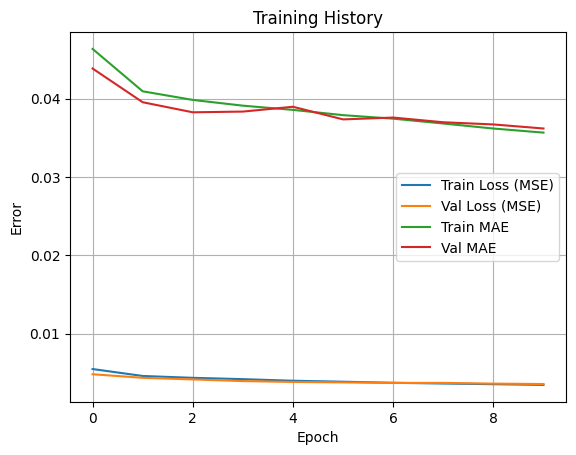

In [ ]:
# ========================
# 8. VISUALIZAR ENTRENAMIENTO
# ========================
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Val Loss (MSE)')
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ========================
# 9. GUARDAR MODELO
# ========================
model.save('model_circuito.h5')
print("✅ Modelo guardado como model_circuito.h5")

✅ Modelo guardado como model_circuito.h5
